# Multi-view Self-supervised Learning for Multivariate Variable Channel Time-series Reimplementation

Student: Andrea Caminiti  
Matricola: 1924053  
E-mail: caminiti.1924053@studenti.uniroma1.it

## Introduction

### Implementation Description

The paper propose a new method for EEG analysis, specifically it is a channel agnostic method to predict sleep stages.  
The method implemented is divided into a pretraining and a finetuing part. 

#### Pretraining

During the pretraining, the model takes in input samples of shape $(N \times C \times T_{in})$ where $N$ is the batch size, $C$ is the number of channels, and $T_{in}$ is the number of time-steps. Each channel is passed singularly to an encoder, that outputs representations of shape $(N \times D \times T_{out})$ where $N$ is the batch size, $D$ is the  embedding dimension, and $T_{out}$ is the number of _reduced_ time-steps.  
We now have two modalities to continue, both will terminate by being fed to a contrastive loss, specifically to a TS2Vec Loss, originally implemented [here](https://arxiv.org/abs/2106.10466):  
- Split View Strategy:  
    Each channel is considered as a view. Thus we have $\frac{C * (C-1)}{2}$ possible pairs for the contrastive loss used to learn the representations to divide the different sleep stages. 
- Grouped View Strategy:  
    Representations are divided randomly into 2 groups of dimension either (2, 4) or (3, 3). Then the groups are passed to a Message Passing Neural Network, that will output two representations, one per group, of shape $(N \times D_{MPNN} \times T_{out})$ where $N$ is the batch size, $D_{MPNN}$ is the embedding dimension of the MPNN, and $T_{out}$ is the number of _reduced_ time-steps from the encoder, thus just one pair for the TS2Vec Loss.  

#### Finetuning

During finetuning we change the loss function to Cross Entropy Loss and we classify.  
The steps done during pretraining are repeated, then the representation are stacked and passed to a Linear layer responsible for channel reduction.  
The final representation is flattened to shape $(N \times D*T_{out})$ where D can be either the embedding dimension of the encoder for the split view strategy or the embedding dimension of the MPNN for the group view strategy. 

### Changes

The following changes have been made with respect to the original paper:
1. Encoder:  
    In the original paper the encoder block was made up, in order, by:  
    1. 1D Convolution  
    2. Dropout  
    3. Group Normalization  
    4. GELU activation function  
      
    While in my reimplementation skip-connections have been introduced and the activation function changed, transforming the block into:  

    1. 1D Convolution
    2. Skip-Connection
    3. Dropout
    4. Group Normalization
    5. Leaky ReLU activation function

2. MPNN:  
    In the original paper they implemented a simple Message Passing Neural Network, in my implementation, I, instead, chose to a different kind of MPNN: a simple convolutional one.

While the change in 2. is based on pure curiosity, the changes in 1. have been necessary to try to solve the Vanishing gradient problem, which has been accomplished.  
However other problems have arised, due to, I suspect, Embedding Collapse. After a lot of research, I found a [paper](https://openreview.net/forum?id=YevsQ05DEN7) stating that the problem may be found in strong augmentations. Indeed a lower probability to apply such augmentations and a smaller learning rate led to better embeddings. 

## Demo

In [1]:
#Install necessary modules
%pip install -r requirements.txt

from model.model import Model
from dataset.datatset import createDataset
from dataset.util import load_fif_file, extract_channels, extract_labels
from copy import deepcopy
from losses import TS2VecLoss
import os
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support
from sklearn.manifold import TSNE


device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 3233
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
datapath = 'data/Dataset/Demo'
for i, f in tqdm(enumerate(os.listdir(datapath)), desc='Loading Dataset...', leave=False):
        path = os.path.join(datapath, f)
        raw = load_fif_file(path)
        raw = extract_channels(raw)
        labels, start = extract_labels(raw)
        chs = np.array([np.split(ch, len(ch)//3000) for ch in raw.get_data()])
        chs = (chs-np.mean(chs))/np.std(chs)

### Embedding Learning

#### Split view strategy

In [3]:
model = Model(view_strat='split')
model.update_classifier(2, 5)
if device == 'cpu':
    model.load_state_dict(torch.load('./models/model_split_finetuned.pt', weights_only=True, map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load('./models/model_split_finetuned.pt', weights_only=True))

model.to(device)
model = model.eval()
loss = TS2VecLoss(0.01)

In [4]:
samples, label = torch.tensor(np.array(deepcopy(chs))), torch.tensor(np.array(deepcopy(labels)))
idxs = np.concatenate([np.where(label == 0)[0][:40], np.where(label == 1)[0][:40], np.where(label == 2)[0][:40], np.where(label == 3)[0][:40], np.where(label == 4)[0][:40]])
idxs = np.random.choice(idxs, len(idxs))
samples = samples.permute(1, 0, 2)[idxs].float()
label = label[idxs].long()  
b, ch, t = samples.shape       
samples.shape

torch.Size([200, 2, 3000])

In [5]:
views = [samples[:, c, :].unsqueeze(1) for c in range(ch)]         
embeddings = torch.stack([model.encode(v.to(device)) for v in views])
embeddings.shape

torch.Size([2, 200, 128, 31])

In [6]:
l = 0.0
for i in range(ch):
    for j in range(i+1, ch): 
        l += loss(embeddings[i], embeddings[j])
l

tensor(26.8693, grad_fn=<AddBackward0>)

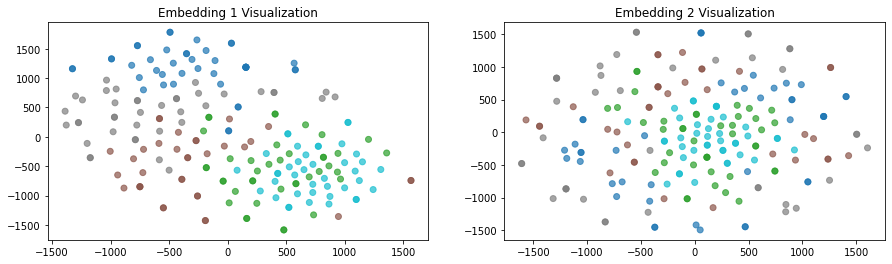

In [7]:
embedding1 = embeddings[0].reshape(embeddings[0].shape[0], -1).detach().cpu().numpy()
embedding2 = embeddings[1].reshape(embeddings[1].shape[0], -1).detach().cpu().numpy()

tsne = TSNE(n_components=2, perplexity=50, random_state=42, init='pca', n_iter=5000)
    
embedding1_2d = tsne.fit_transform(embedding1)
embedding2_2d = tsne.fit_transform(embedding2)

fig, (e1, e2) = plt.subplots(1, 2)

fig.set_figwidth(15)
scatter1 = e1.scatter(embedding1_2d[:, 0], embedding1_2d[:, 1], c=label, cmap='tab10', alpha=0.7)
e1.set_title("Embedding 1 Visualization")

scatter2 = e2.scatter(embedding2_2d[:, 0], embedding2_2d[:, 1], c=label, cmap='tab10', alpha=0.7)
e2.set_title("Embedding 2 Visualization")
plt.show()

#### Group view strategy

In [8]:
model = Model(view_strat='group')
if device == 'cpu':
    model.load_state_dict(torch.load('./models/model_mpnn_conv_group_finetuned.pt', weights_only=True, map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load('./models/model_mpnn_conv_group_finetuned.pt', weights_only=True))

model.to(device)
model = model.eval()
loss = TS2VecLoss(0.01)

In [9]:
samples, label = torch.tensor(np.array(deepcopy(chs))), torch.tensor(np.array(deepcopy(labels)))
idxs = np.concatenate([np.where(label == 0)[0][:40], np.where(label == 1)[0][:40], np.where(label == 2)[0][:40], np.where(label == 3)[0][:40], np.where(label == 4)[0][:40]])
idxs = np.random.choice(idxs, len(idxs))
samples = samples.permute(1, 0, 2)[idxs].float()
label = label[idxs].long()  
b, ch, t = samples.shape       
samples.shape

torch.Size([200, 2, 3000])

In [10]:
permuted_indices = torch.randperm(ch)
sep = 1 if ch <= 2 else torch.randint(low=2, high=ch-1, size=(1,))
group1 = permuted_indices[:sep]
group2 = permuted_indices[sep:]
v1, v2 = samples[:, group1, :], samples[:, group2, :]

v1 = v1.view(b*len(group1), 1, t)
v2 = v2.view(b*len(group2), 1, t) 

embedding1 = model.encode(v1.to(device))
embedding2 = model.encode(v2.to(device))

print(f'Embeddings of view 1 shape: {embedding1.shape}')
print(f'Embeddings of view 2 shape: {embedding2.shape}')

Embeddings of view 1 shape: torch.Size([200, 128, 31])
Embeddings of view 2 shape: torch.Size([200, 128, 31])


In [11]:
embedding1 = model.message(embedding1.permute(2, 0, 1), b, len(group1)).permute(1, 0, 2)
embedding2 = model.message(embedding2.permute(2, 0, 1), b, len(group2)).permute(1, 0, 2)

embedding1 = embedding1.view(b, len(group1), *embedding1.shape[1:]).sum(dim=1)
embedding2 = embedding2.view(b, len(group2), *embedding2.shape[1:]).sum(dim=1)

embedding1 = model.mpnn.rout(embedding1).permute(0, 2, 1)
embedding2 = model.mpnn.rout(embedding2).permute(0, 2, 1)

print(f'Embeddings of view 1 shape: {embedding1.shape}')
print(f'Embeddings of view 2 shape: {embedding2.shape}')

Embeddings of view 1 shape: torch.Size([200, 128, 31])
Embeddings of view 2 shape: torch.Size([200, 128, 31])


In [12]:
l = loss(embedding1, embedding2)
l

tensor(44.1058, grad_fn=<DivBackward0>)

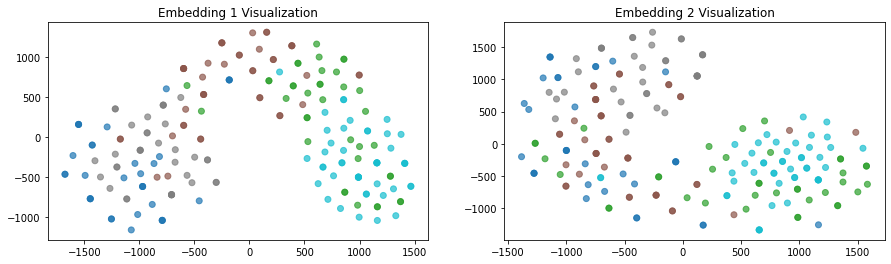

In [13]:
embedding1 = embedding1.reshape(embedding1.shape[0], -1).detach().cpu().numpy()
embedding2 = embedding2.reshape(embedding2.shape[0], -1).detach().cpu().numpy()

tsne = TSNE(n_components=2, perplexity=50, random_state=42, init='pca', n_iter=5000)
    
embedding1_2d = tsne.fit_transform(embedding1)
embedding2_2d = tsne.fit_transform(embedding2)

fig, (e1, e2) = plt.subplots(1, 2)

fig.set_figwidth(15)
scatter1 = e1.scatter(embedding1_2d[:, 0], embedding1_2d[:, 1], c=label, cmap='tab10', alpha=0.7)
e1.set_title("Embedding 1 Visualization")

scatter2 = e2.scatter(embedding2_2d[:, 0], embedding2_2d[:, 1], c=label, cmap='tab10', alpha=0.7)
e2.set_title("Embedding 2 Visualization")
plt.show()

### Classification

#### Split view strategy

In [14]:
model = Model(view_strat='split')
model.update_classifier(2, 5)
if device == 'cpu':
    model.load_state_dict(torch.load('./models/model_split_finetuned.pt', weights_only=True, map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load('./models/model_split_finetuned.pt', weights_only=True))
model.to(device)
model = model.eval()
loss = torch.nn.CrossEntropyLoss()

In [15]:
samples, label = torch.tensor(np.array(deepcopy(chs))), torch.tensor(np.array(deepcopy(labels)))
idxs = np.concatenate([np.where(label == 0)[0][:40], np.where(label == 1)[0][:40], np.where(label == 2)[0][:40], np.where(label == 3)[0][:40], np.where(label == 4)[0][:40]])
idxs = np.random.choice(idxs, len(idxs))
samples = samples.permute(1, 0, 2)[idxs].float()
label = label[idxs].long()  
b, ch, t = samples.shape       
samples.shape

torch.Size([200, 2, 3000])

In [16]:
views = [samples[:, c, :].unsqueeze(1) for c in range(ch)]
views[0].shape         

torch.Size([200, 1, 3000])

In [17]:
embeddings = torch.stack([model.encode(v.to(device)) for v in views])
embeddings.shape

torch.Size([2, 200, 128, 31])

In [18]:
res = model.classify(embeddings.permute(1, 2, 3, 0))
res.shape

torch.Size([200, 5])

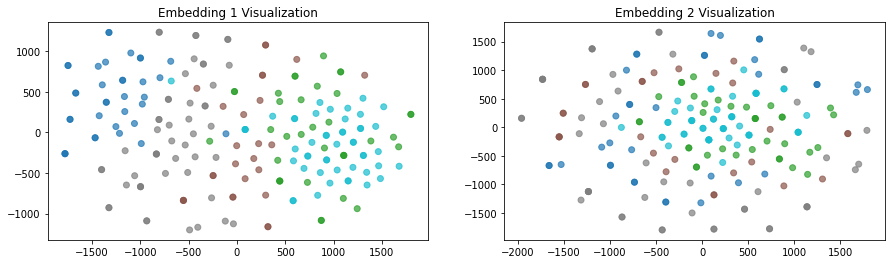

In [19]:
embedding1 = embeddings[0].reshape(embeddings[0].shape[0], -1).detach().cpu().numpy()
embedding2 = embeddings[1].reshape(embeddings[1].shape[0], -1).detach().cpu().numpy()

tsne = TSNE(n_components=2, perplexity=50, random_state=42, init='pca', n_iter=5000)
    
embedding1_2d = tsne.fit_transform(embedding1)
embedding2_2d = tsne.fit_transform(embedding2)

fig, (e1, e2) = plt.subplots(1, 2)

fig.set_figwidth(15)
scatter1 = e1.scatter(embedding1_2d[:, 0], embedding1_2d[:, 1], c=label, cmap='tab10', alpha=0.7)
e1.set_title("Embedding 1 Visualization")

scatter2 = e2.scatter(embedding2_2d[:, 0], embedding2_2d[:, 1], c=label, cmap='tab10', alpha=0.7)
e2.set_title("Embedding 2 Visualization")
plt.show()

In [20]:
loss = loss(res, label).item()
preds = res.argmax(dim=1).cpu()
label = label.cpu()
loss

0.7771850824356079

In [21]:
acc = balanced_accuracy_score(label, preds)
prec, rec, f, _ = precision_recall_fscore_support(label, preds, average='weighted', labels=np.arange(5, step=1))
print(f'Accuracy: {acc:.6f}\nPrecision: {prec:.6f}\nRecall: {rec:.6f}\nF-Score: {f:.6f}')               

Accuracy: 0.678610
Precision: 0.687606
Recall: 0.705000
F-Score: 0.678278


#### Group view strategy

In [22]:
model = Model(view_strat='group')
if device == 'cpu':
    model.load_state_dict(torch.load('./models/model_mpnn_conv_group_finetuned.pt', weights_only=True, map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load('./models/model_mpnn_conv_group_finetuned.pt', weights_only=True))
model.to(device)
model = model.eval()
loss = torch.nn.CrossEntropyLoss()

In [23]:
samples, label = torch.tensor(np.array(deepcopy(chs))), torch.tensor(np.array(deepcopy(labels)))
idxs = np.concatenate([np.where(label == 0)[0][:40], np.where(label == 1)[0][:40], np.where(label == 2)[0][:40], np.where(label == 3)[0][:40], np.where(label == 4)[0][:40]])
idxs = np.random.choice(idxs, len(idxs))
samples = samples.permute(1, 0, 2)[idxs].float()
label = label[idxs].long()  
b, ch, t = samples.shape       
samples.shape

torch.Size([200, 2, 3000])

In [24]:
permuted_indices = torch.randperm(ch)
sep = 1 if ch <= 2 else torch.randint(low=2, high=ch-1, size=(1,))
group1 = permuted_indices[:sep]
group2 = permuted_indices[sep:]
v1, v2 = samples[:, group1, :], samples[:, group2, :]

v1 = v1.view(b*len(group1), 1, t)
v2 = v2.view(b*len(group2), 1, t) 

embedding1 = model.encode(v1.to(device))
embedding2 = model.encode(v2.to(device))

print(f'Embeddings of view 1 shape: {embedding1.shape}')
print(f'Embeddings of view 2 shape: {embedding2.shape}')

Embeddings of view 1 shape: torch.Size([200, 128, 31])
Embeddings of view 2 shape: torch.Size([200, 128, 31])


In [25]:
embedding1 = model.message(embedding1.permute(2, 0, 1), b, len(group1)).permute(1, 0, 2)
embedding2 = model.message(embedding2.permute(2, 0, 1), b, len(group2)).permute(1, 0, 2)

embedding1 = embedding1.view(b, len(group1), *embedding1.shape[1:]).sum(dim=1)
embedding2 = embedding2.view(b, len(group2), *embedding2.shape[1:]).sum(dim=1)

embedding1 = model.mpnn.rout(embedding1).permute(0, 2, 1)
embedding2 = model.mpnn.rout(embedding2).permute(0, 2, 1)

print(f'Embeddings of view 1 shape: {embedding1.shape}')
print(f'Embeddings of view 2 shape: {embedding2.shape}')

Embeddings of view 1 shape: torch.Size([200, 128, 31])
Embeddings of view 2 shape: torch.Size([200, 128, 31])


In [26]:
embeddings = torch.stack((embedding1, embedding2)).permute(1, 2, 3, 0)
print(f'Final Embedding shape: {embeddings.shape}')

Final Embedding shape: torch.Size([200, 128, 31, 2])


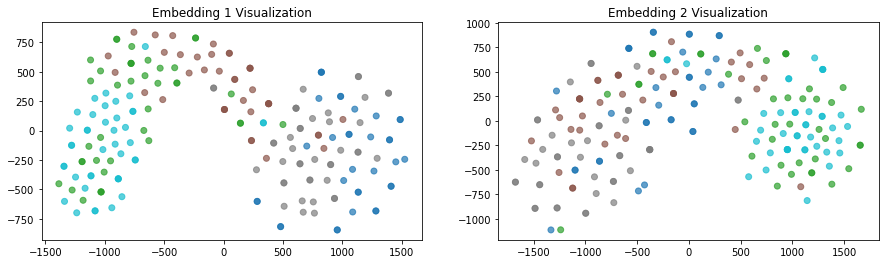

In [27]:
embedding1 = embedding1.reshape(embedding1.shape[0], -1).detach().cpu().numpy()
embedding2 = embedding2.reshape(embedding2.shape[0], -1).detach().cpu().numpy()

tsne = TSNE(n_components=2, perplexity=50, random_state=42, init='pca', n_iter=5000)
    
embedding1_2d = tsne.fit_transform(embedding1)
embedding2_2d = tsne.fit_transform(embedding2)

fig, (e1, e2) = plt.subplots(1, 2)

fig.set_figwidth(15)
scatter1 = e1.scatter(embedding1_2d[:, 0], embedding1_2d[:, 1], c=label, cmap='tab10', alpha=0.7)
e1.set_title("Embedding 1 Visualization")

scatter2 = e2.scatter(embedding2_2d[:, 0], embedding2_2d[:, 1], c=label, cmap='tab10', alpha=0.7)
e2.set_title("Embedding 2 Visualization")
plt.show()

In [28]:
res = model.classify(embeddings)
res.shape

torch.Size([200, 5])

In [29]:
loss = loss(res, label).item()
preds = res.argmax(dim=1).cpu()
label = label.cpu()
loss

1.069565773010254

In [30]:
acc = balanced_accuracy_score(label, preds)
prec, rec, f, _ = precision_recall_fscore_support(label, preds, average='weighted', labels=np.arange(5, step=1))
print(f'Accuracy: {acc:.6f}\nPrecision: {prec:.6f}\nRecall: {rec:.6f}\nF-Score: {f:.6f}')

Accuracy: 0.589332
Precision: 0.540181
Recall: 0.585000
F-Score: 0.524489


# Results

All the experimental results can be found in the `logs` directory with their evolution epoch by epoch and, in the `*_finetuned` files, the classification results that are summarized in the table below.  

| View Strategy with 50 samples per class | Accuracy (paper) |  Accuracy (re-implementation) | Precision (re-implementation) | Recall (re-implementation) | F-score (re-implementation) |
| -----------                             | -----------      | -----------                   |-----------                    |-----------                 |-----------                  |
| Split                                   | 0.605            | 0.571                         |0.550                          |0.585                       |0.554                        |
| Group                                   | 0.656            | 0.499                         |0.485                          |0.511                       |0.469                        |

As the table shows, the re-implementation has reached promising results, a possible base for further research focused on the encoder, achieving nearly the same level of accuracy as the implementation of the paper. It is worth noting, that the re-implementation has been heavily limited by the available hardware. The training has been conducted with way fewer windows than in the paper implementation.   
A subset of all the available files of the original datasets has been used, with a maximum of 200 windows per file.